In [1]:
import numpy as np
import time
import psutil
from scipy.linalg import lu_factor, lu_solve, ldl
from scipy.sparse import csc_matrix, bmat
from scipy.sparse.linalg import splu, spsolve
import matplotlib.pyplot as plt

# 1.3

# Equality Solver

In [2]:
# measure CPU usage
def measure_cpu_usage(interval=1.0):
    return psutil.cpu_percent(interval=interval)

In [3]:

def EqualityQPSolverLUdense(H, g, A, b):
    start_time = time.time()
    start_cpu = time.process_time()

    n = H.shape[0]
    m = A.shape[1]
    KKT = np.block([
        [H, A],
        [A.T, np.zeros((m, m))]
    ])
    rhs = np.concatenate([-g, b])
    lu, piv = lu_factor(KKT)
    sol = lu_solve((lu, piv), rhs)
    x = sol[:n]
    lam = sol[n:]

    r1 = H @ x + g + A @ lam
    r2 = A.T @ x - b
    Bn = np.linalg.norm(np.concatenate([r1, r2]))

    end_time = time.time()
    end_cpu = time.process_time()

    elapsed_time = end_time - start_time
    cpu_usage = end_cpu - start_cpu

    return x, lam, Bn, elapsed_time, cpu_usage

def EqualityQPSolverLUsparse(H, g, A, b):
    start_time = time.time()
    start_cpu = time.process_time()
    
    n = H.shape[0]
    m = A.shape[1]  # Correct: 2 in your case
    Hs = csc_matrix(H)
    As = csc_matrix(A.T)  # ✅ Transpose to make it m×n

    KKT = bmat([
        [Hs, -As.T],
        [As, None]
    ], format='csc')
    
    rhs = np.concatenate([-g, b])
    lu = splu(KKT)
    sol = lu.solve(rhs)
    x = sol[:n]
    lam = sol[n:]

    r1 = H @ x + g + A @ lam
    r2 = A.T @ x - b
    Bn = np.linalg.norm(np.concatenate([r1, r2]))

    end_time = time.time()
    end_cpu = time.process_time()
    
    elapsed_time = end_time - start_time
    cpu_usage = end_cpu - start_cpu

    return x, lam, Bn, elapsed_time, cpu_usage


def EqualityQPSolverLDLdense(H, g, A, b):
    start_time = time.time()
    start_cpu = time.process_time()
    
    n = H.shape[0]
    m = A.shape[1]  # FIX: number of constraints
    KKT = np.block([
        [H, A],
        [A.T, np.zeros((m, m))]
    ])
    rhs = np.concatenate([-g, b])
    
    L, D, perm = ldl(KKT)  # L D Lᵀ = Pᵀ KKT P
    P = np.eye(KKT.shape[0])[:, perm]  # permutation matrix

    rhs_permuted = P.T @ rhs
    y = np.linalg.solve(L, rhs_permuted)
    z = np.linalg.solve(D, y)
    w = np.linalg.solve(L.T, z)
    sol = P @ w

    
    x = sol[:n]
    lam = sol[n:]
    
    r1 = H @ x + g + A @ lam
    r2 = A.T @ x - b
    Bn = np.linalg.norm(np.concatenate([r1, r2]))
    
    end_time = time.time()
    end_cpu = time.process_time()
    
    elapsed_time = end_time - start_time
    cpu_usage = end_cpu - start_cpu
    
    return x, lam, Bn, elapsed_time, cpu_usage


def EqualityQPSolverLDLsparse(H, g, A, b):
 #doesnt work
 return ('dosent work in python')

def EqualityQPSolverRangeSpace(H, g, A, b):
    start_time = time.time()
    start_cpu = time.process_time()

    # Ensure A is shape (n, m) where n = number of variables, m = number of constraints
    if A.shape[0] != H.shape[0]:
        A = A.T  # A should be (5, 2) for H (5, 5)

    # Solve H^{-1} A^T once
    H_inv_A_T = np.linalg.solve(H, A.T)  # shape: (5, 2)
    S = A @ H_inv_A_T                   # shape: (2, 2)
    rhs = b + A @ np.linalg.solve(H, g)
    lam = np.linalg.solve(S, rhs)
    x = -np.linalg.solve(H, g - A.T @ lam)

    r1 = H @ x + g + A @ lam
    r2 = A.T @ x - b
    Bn = np.linalg.norm(np.concatenate([r1, r2]))

    end_time = time.time()
    end_cpu = time.process_time()

    elapsed_time = end_time - start_time
    cpu_time = end_cpu - start_cpu

    return x, lam, Bn, elapsed_time, cpu_time


def EqualityQPSolverNullSpace(H, g, A, b):
    start_time = time.time()
    start_cpu = time.process_time()

    from scipy.linalg import null_space

    # Ensure A is n×m (5×2) and A^T x = b
    if A.shape[0] != H.shape[0]:
        A = A.T

    # Null space method
    Z = null_space(A.T)  # Null space of A^T has dimension n - m

    # Find feasible x0 such that A^T x0 = b
    x0 = np.linalg.lstsq(A.T, b, rcond=None)[0]

    Hz = Z.T @ H @ Z
    gz = Z.T @ (H @ x0 + g)
    p = -np.linalg.solve(Hz, gz)
    x = x0 + Z @ p

    lam = np.linalg.lstsq(A, H @ x + g, rcond=None)[0]

    r1 = H @ x + g + A @ lam
    r2 = A.T @ x - b
    Bn = np.linalg.norm(np.concatenate([r1, r2]))

    end_time = time.time()
    end_cpu = time.process_time()

    elapsed_time = end_time - start_time
    cpu_usage = end_cpu - start_cpu

    return x, lam, Bn, elapsed_time, cpu_usage


def EqualityQPSolver(H, g, A, b, solver):
    solvers = {
        "LUdense": EqualityQPSolverLUdense,
        "LUsparse": EqualityQPSolverLUsparse,
        "LDLdense": EqualityQPSolverLDLdense,
        "LDLsparse": EqualityQPSolverLDLsparse,
        "RangeSpace": EqualityQPSolverRangeSpace,
        "NullSpace": EqualityQPSolverNullSpace
    }
    if solver not in solvers:
        raise ValueError(f"Unknown solver: {solver}")
    return solvers[solver](H, g, A, b)


In [4]:
def generate_test_problem(n, beta, alpha):
    # Generate random matrix M with 15% nonzero elements
    M = np.random.randn(n, n)
    mask_M = np.random.rand(n, n) > 0.85
    M[mask_M] = 0
    
    # Generate H = M M' + alpha I
    H = M @ M.T + alpha * np.eye(n)
    
    # Generate random vector g
    g = np.random.randn(n)
    
    # Generate matrix A with 15% nonzero elements
    m = round(beta * n)
    A = np.random.randn(m, n)
    mask_A = np.random.rand(m, n) > 0.85
    A[mask_A] = 0

    # Transpose A so shape is (n × m), as expected by solver
    A = A.T
    
    # Generate random vector b
    b = np.random.randn(m)
    
    return H, g, A, b

def compute_lagrangian(H, g, A, b, x, lam):
    L = 0.5 * x.T @ H @ x + g.T @ x - np.dot(lam, (A.T @ x - b))
    return L


In [14]:
# Parameters
n = 100  # Size of x
beta = 0.5  # Ratio for size of A
alpha = 1.0 # Regularization parameter

# Generate test problem
np.random.seed(237)  # Set seed once, before generating data
H, g, A, b = generate_test_problem(n, beta, alpha)

# Print the variables, so it can be used in MatLab as well
print("x:", x)
print("lam:", lam)
print("A:", (A))
print("b:", b)

x: [ 0.33880081 -0.22452428  0.4798613  -0.00212883  0.40799099]
lam: [-2.29698186 -0.3260314   0.33005863 -2.06166892  4.41692342  1.29560468
  6.81561176  4.99909933 -3.11165277 -2.06439077 -3.23336899 -0.69759253
 -1.64243306 -0.81114595 -0.73757292 -2.83236725 -0.78344305  3.7437483
  1.94896547  2.98423593  0.33416375 -2.21001314  0.02136868  4.47505733
 -1.78144122  0.18917774 -3.18363112 -1.26939017 -5.27015915  1.55053069
 -2.02527489  0.17242609  1.81568433  2.04106741  4.14979919 -2.4153793
 -0.37000474 -2.15017626  0.3575979   7.36978965 -1.8257302  -4.39732959
 -2.58755354 -5.88520443 -2.76732951 -5.74483857  0.90946133 -0.50808127
 -1.99806742  1.01169251]
A: [[ 0.28646832  0.          0.76146661 ... -0.98058695 -1.18936813
   0.88159764]
 [-0.1339306   0.          0.         ... -1.36675387 -1.14000146
   0.30531095]
 [ 0.07032156 -0.24193515  0.         ... -0.25269654  0.
  -0.07049113]
 ...
 [ 0.85650113 -0.69638598 -0.73014593 ... -0.22742775 -0.16623236
  -0.51151305

In [ ]:
# x, lam, time1, cpu1 = EqualityQPSolver(H, g, A, b, 'LDLsparse')
# L = compute_lagrangian(H, g, A, b, x, lam)
# L, time1, cpu1 

In [10]:
x, lam, Bn, time1, cpu1 = EqualityQPSolver(H, g, A, b, 'LUdense')
L = compute_lagrangian(H, g, A, b, x, lam)
print(f"This is the LU dense, L: {L:.4f}, time1: {time1:.4f}, cpu: {cpu1:.4f}")

This is the LU dense, L: 50.7140, time1: 0.0042, cpu: 0.0099


In [7]:
x, lam, Bn, time1, cpu1 = EqualityQPSolver(H, g, A, b, 'LUsparse')
L = compute_lagrangian(H, g, A, b, x, lam)
print(f"This is the LU sparse, L: {L:.4f}, time1: {time1:.4f}, cpu: {cpu1:.4f}")

This is the LU sparse, L: 50.7140, time1: 0.0126, cpu: 0.0110


In [8]:
x, lam, Bn, time1, cpu1 = EqualityQPSolver(H, g, A, b, 'LDLdense')
L = compute_lagrangian(H, g, A, b, x, lam)
print(f"This is the LDLdense, L: {L:.4f}, time1: {time1:.4f}, cpu: {cpu1:.4f}")

This is the LDLdense, L: 50.7140, time1: 0.0102, cpu: 0.0102


In [9]:
x, lam, Bn, time1, cpu1 = EqualityQPSolver(H, g, A, b, 'RangeSpace')
L = compute_lagrangian(H, g, A, b, x, lam)
print(f"This is the Range space, L: {L:.4f}, time1: {time1:.4f}, cpu: {cpu1:.4f}")

ValueError: solve: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (m,m),(m,n)->(m,n) (size 50 is different from 100)

In [12]:
x, lam, Bn, time1, cpu1 = EqualityQPSolver(H, g, A, b, 'NullSpace')
L = compute_lagrangian(H, g, A, b, x, lam)
print(f"This is the NullSpace, L: {L:.4f}, time1: {time1:.4f}, cpu: {cpu1:.4f}")

This is the NullSpace, L: 50.7140, time1: 0.0554, cpu: 0.0580


# 1.6

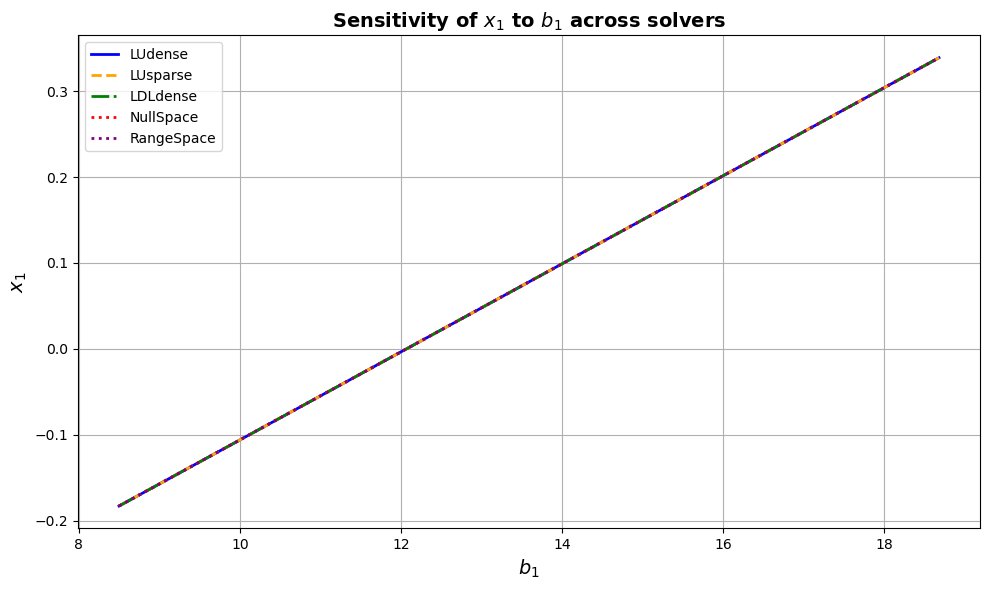

In [13]:
# Problem data
H = np.array([
    [6.0000, 1.8600, 1.2400, 1.4800, -0.4600],
    [1.8600, 4.0000, 0.4400, 1.1200, 0.5200],
    [1.2400, 0.4400, 3.8000, 1.5600, -0.5400],
    [1.4800, 1.1200, 1.5600, 7.2000, -1.1200],
    [-0.4600, 0.5200, -0.5400, -1.1200, 7.8000]
])
g = np.array([-16.1000, -8.5000, -15.7000, -10.0200, -18.6800])
A_base = np.array([
    [16.1000, 1.0000],
    [8.5000, 1.0000],
    [15.7000, 1.0000],
    [10.0200, 1.0000],
    [18.6800, 1.0000]
])

# Sweep over b₁
b1_values = np.linspace(8.5, 18.68, 100)

x1_LUdense = []
x1_LUsparse = []
x1_LDLdense = []
x1_NullSpace = []

for b1 in b1_values:
    b = np.array([b1, 1.0])
    A = A_base.copy()  # Avoid mutation issues

    x, _, _, _, _ = EqualityQPSolver(H, g, A, b, 'LUdense')
    x1_LUdense.append(x[0])

    x, _, _, _, _ = EqualityQPSolver(H, g, A, b, 'LUsparse')
    x1_LUsparse.append(x[0])

    x, _, _, _, _ = EqualityQPSolver(H, g, A, b, 'LDLdense')
    x1_LDLdense.append(x[0])

    x, _, _, _, _ = EqualityQPSolver(H, g, A, b, 'NullSpace')
    x1_NullSpace.append(x[0])

# Plot
plt.figure(figsize=(10, 6))
plt.plot(b1_values, x1_LUdense, label='LUdense', lw=2, color='blue', linestyle='-')
plt.plot(b1_values, x1_LUsparse, label='LUsparse', lw=2, color='orange', linestyle='--')
plt.plot(b1_values, x1_LUdense, label='LDLdense', lw=2, color='green', linestyle='-.')
plt.plot(b1_values, x1_NullSpace, label='NullSpace', lw=2, color='red', linestyle=':')
plt.plot(b1_values, x1_NullSpace, label='RangeSpace', lw=2, color='purple', linestyle='dotted')

plt.xlabel(r'$b_1$', fontsize=14, fontweight='bold')
plt.ylabel(r'$x_1$', fontsize=14, fontweight='bold')
plt.title(r'Sensitivity of $x_1$ to $b_1$ across solvers', fontsize=14, fontweight='bold')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
